In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from gensim.models import Word2Vec,Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score

In [98]:
# read sample data
sample_df = pd.read_csv("../../data/sample_data_item_name_features.csv", index_col=0)
sample_df.head(3)

,train_id,name,upper_word_count,upper_char_count,bef_word_count,bef_char_count,stopword_count,punctuation_count,number_count,bef_avg_word_len,clean_name,aft_word_count,aft_char_count,aft_avg_word_len
0,748447,Polaroid Camera,0,2,2,15,0,0,0,7.5,polaroid camera,2,15,7.50
1,674932,Vintage Ashtray,0,2,2,15,0,0,0,7.5,vantage astray,2,14,7.00
2,586672,Matilda Jane weekender nwt,0,2,4,26,0,0,0,6.5,manila jane weekend not,4,23,5.75


In [99]:
corpus = sample_df.clean_name.to_list()

In [126]:
# sample_df.train_id = sample_df.train_id.apply(str)
sample_df['price'] = pd.read_csv("../../data/sample_data.csv").price.values
train, test = train_test_split(sample_df, test_size=0.3, random_state=42)

# HashingVectorizer

In [194]:
hv = HashingVectorizer(n_features=20)
X_train = hv.fit_transform(train.clean_name.to_list())
X_test = hv.transform(test.clean_name.to_list())

y_train = train.price.to_list()
y_test = test.price.to_list()

<AxesSubplot:>

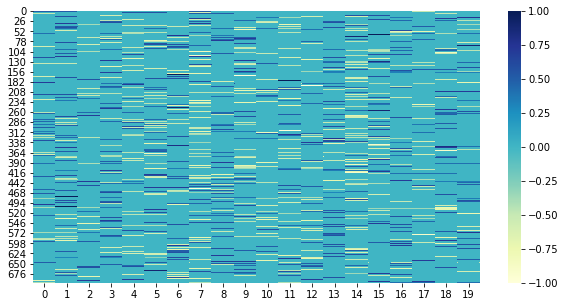

In [195]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(X_train.toarray(),ax =ax, cmap="YlGnBu" )

In [196]:
linreg = LinearRegression().fit(X_train, y_train)
y_test_pred = linreg.predict(X_test)
print('MSE: %s' % mean_squared_error(y_test, y_test_pred))
print('MAE: %s'% mean_absolute_error(y_test, y_test_pred))

MSE: 1755.758995868396
MAE: 19.328485840979802


In [197]:
y_train_pred = linreg.predict(X_train)
print('MSE: %s' % mean_squared_error(y_train, y_train_pred))
print('MAE: %s'% mean_absolute_error(y_train, y_train_pred))

MSE: 725.0480298292632
MAE: 16.84299136508587


<AxesSubplot:>

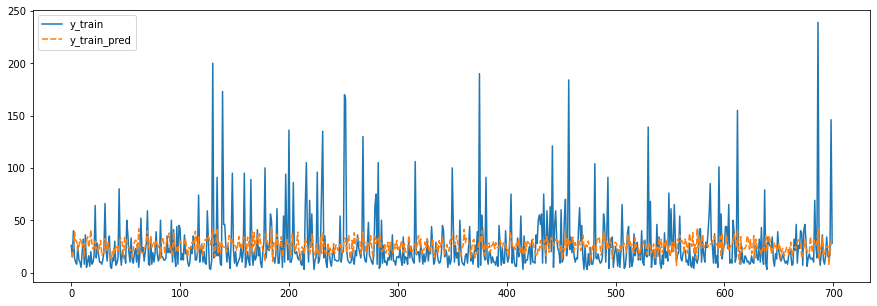

In [198]:
pred_df = pd.DataFrame({'y_train':y_train, 'y_train_pred':y_train_pred})
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pred_df, ax=ax)

<AxesSubplot:>

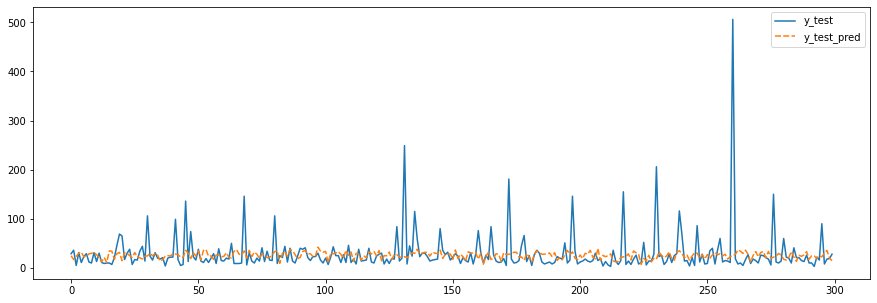

In [199]:
pred_df = pd.DataFrame({'y_test':y_test, 'y_test_pred':y_test_pred})
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pred_df, ax=ax)

# TfidfVectorizer

In [200]:
hv = TfidfVectorizer(max_features=20)
X_train = hv.fit_transform(train.clean_name.to_list())
X_test = hv.transform(test.clean_name.to_list())

y_train = train.price.to_list()
y_test = test.price.to_list()

<AxesSubplot:>

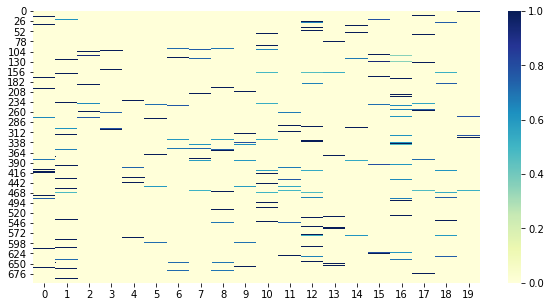

In [201]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(X_train.toarray(),ax =ax, cmap="YlGnBu" )

In [202]:
linreg = LinearRegression().fit(X_train, y_train)
y_test_pred = linreg.predict(X_test)
print('MSE: %s' % mean_squared_error(y_test, y_test_pred))
print('MAE: %s'% mean_absolute_error(y_test, y_test_pred))

MSE: 1739.4827584262216
MAE: 18.92118683090371


In [203]:
y_train_pred = linreg.predict(X_train)
print('MSE: %s' % mean_squared_error(y_train, y_train_pred))
print('MAE: %s'% mean_absolute_error(y_train, y_train_pred))

MSE: 725.719055232555
MAE: 16.320957394841177


<AxesSubplot:>

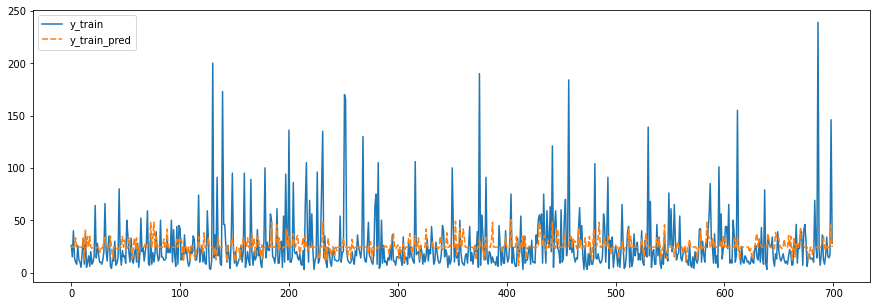

In [204]:
pred_df = pd.DataFrame({'y_train':y_train, 'y_train_pred':y_train_pred})
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pred_df, ax=ax)

<AxesSubplot:>

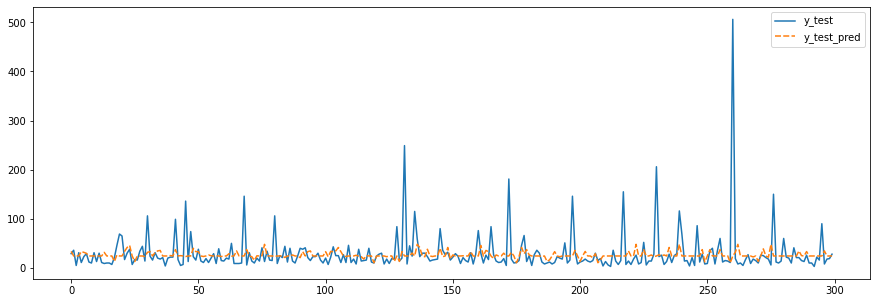

In [205]:
pred_df = pd.DataFrame({'y_test':y_test, 'y_test_pred':y_test_pred})
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pred_df, ax=ax)

# Word2Vec modeling

In [102]:
# Word2Vec modeling. 
model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=8)
# model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
# model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

In [112]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['clean_name'].split(' '), tags = [r.price]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['clean_name'].split(' '), tags = [r.price]), axis=1)

# test_tagged.values

In [114]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=8)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 700/700 [00:00<00:00, 1463615.55it/s]


In [131]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [132]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [185]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [189]:
linreg = LinearRegression().fit(X_train, y_train)
y_test_pred = linreg.predict(X_test)
print('MSE: %s' % mean_squared_error(y_test, y_test_pred))
print('MAE: %s'% mean_absolute_error(y_test, y_test_pred))

MSE: 2380.889254513305
MAE: 29.16293625831604


In [190]:
y_train_pred = linreg.predict(X_train)
print('MSE: %s' % mean_squared_error(y_train, y_train_pred))
print('MAE: %s'% mean_absolute_error(y_train, y_train_pred))

MSE: 437.47617728593843
MAE: 15.257970782688686


<AxesSubplot:>

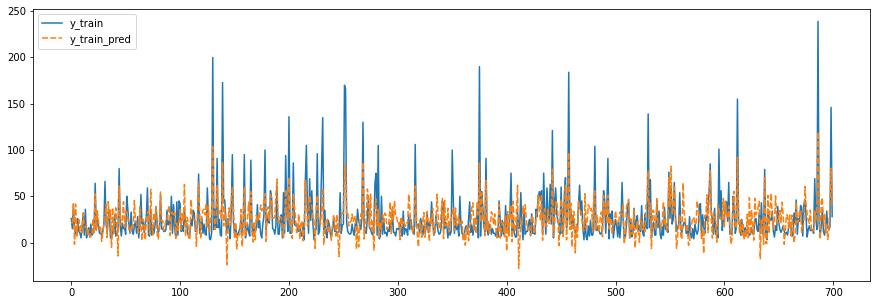

In [191]:
pred_df = pd.DataFrame({'y_train':y_train, 'y_train_pred':y_train_pred})
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pred_df, ax=ax)

<AxesSubplot:>

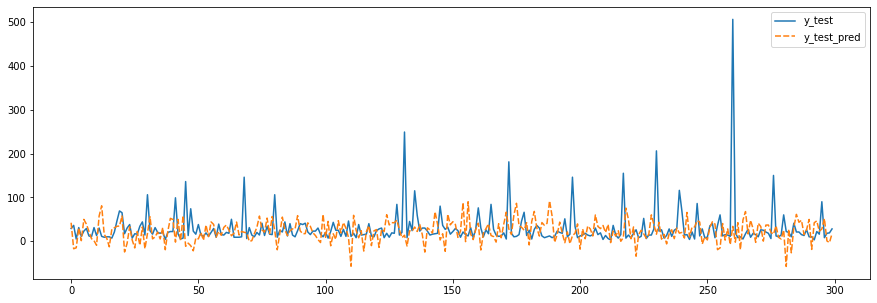

In [193]:
pred_df = pd.DataFrame({'y_test':y_test, 'y_test_pred':y_test_pred})
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pred_df, ax=ax)

# No Train Test Split

In [206]:
hv = HashingVectorizer(n_features=50)
hX = hv.fit_transform(sample_df.clean_name.to_list())

hreg = LinearRegression().fit(hX.toarray(), y)
y_hpred = hreg.predict(hX.toarray())
print('MSE: %s' % mean_squared_error(y, y_hpred))
print('MAE: %s'% mean_absolute_error(y, y_hpred))

MSE: 993.2640557386202
MAE: 17.730212287308053


In [207]:
tfV = TfidfVectorizer(max_features=50)
tfX = tfV.fit_transform(sample_df.clean_name.to_list())

tfreg = LinearRegression().fit(tfX.toarray(), y)
y_tfpred = tfreg.predict(tfX.toarray())
print('MSE: %s' % mean_squared_error(y, y_tfpred))
print('MAE: %s'% mean_absolute_error(y, y_tfpred))

MSE: 967.9012665356819
MAE: 16.801775530558437


In [208]:
pred_df = pd.DataFrame({'y':y, 'y_hpred':y_hpred, 'y_tpred':y_tfpred})

<AxesSubplot:>

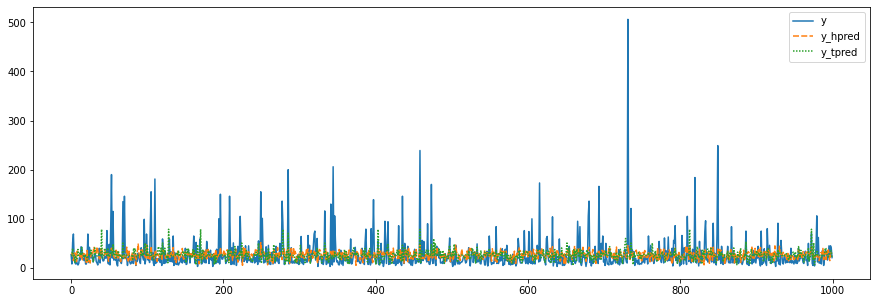

In [209]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pred_df, ax=ax)

# Final Selection for Item Name Feature Extraction: TfidfVectorizer 